In [7]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, ADASYN

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
import graphviz

from google.colab import drive

column_names = {
    0: "age",
    1: "workclass",
    2: "fnlwgt",
    3: "education",
    4: "education-num",
    5: "marital-status",
    6: "occupation",
    7: "relationship",
    8: "race",
    9: "sex",
    10: "capital-gain",
    11: "capital-loss",
    12: "hours-per-week",
    13: "native-country",
    14: "income"
}

In [8]:
drive.mount('/content/drive')
train_file = '/content/drive/My Drive/lab3_ClassificationUsingDecisionTree/train.csv'
test_file = '/content/drive/My Drive/lab3_ClassificationUsingDecisionTree/test.csv'

train = pd.read_csv(train_file, header=None)
test = pd.read_csv(test_file, header=None)

train.rename(columns=column_names, inplace=True)
test.rename(columns=column_names, inplace=True)
test['income'] = test['income'].str.rstrip('.')

dataset = pd.concat([train, test])

print("Количество записей с значением  <=50K  --> ", len(dataset[dataset['income'] == ' <=50K']))
print("Количество записей с значением  >50K  --> ", len(dataset[dataset['income'] == ' >50K']))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Количество записей с значением  <=50K  -->  37155
Количество записей с значением  >50K  -->  11687


In [9]:
# Метрики
def classification_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    return accuracy, precision, recall, f1


# Балансировка датасета
def balance_dataset(dataset):
    # Разделение на признаки и метки
    X = dataset.drop(columns=['income'])
    y = dataset['income']

    # Преобразование меток классов в числовые значения (0 и 1)
    y_numeric = (y == ' >50K').astype(int)

    # Создание экземпляра RandomOverSampler
    ros = RandomOverSampler(random_state=42)

    # Применение RandomOverSampler к данным
    X_resampled, y_resampled = ros.fit_resample(X, y_numeric)

    # Преобразование обратно в DataFrame
    X_balanced = pd.DataFrame(X_resampled, columns=X.columns)
    y_balanced = pd.Series(y_resampled)

    # Объединение признаков и меток обратно в DataFrame
    balanced_dataset = pd.concat([X_balanced, y_balanced], axis=1)
    balanced_dataset['income'] = balanced_dataset['income'].map({0: ' <=50K', 1: ' >50K'})

    return balanced_dataset

# Обучения дерева решений
def classify_dataset(dataset, criterion, test_size=0.2):
    balanced_dataset = balance_dataset(dataset)

    # Преобразование категориальных признаков в числовые с помощью LabelEncoder
    dataset_encoded = balanced_dataset.copy()
    label_encoder = LabelEncoder()
    for column in dataset_encoded.select_dtypes(include=['object']).columns:
        dataset_encoded[column] = label_encoder.fit_transform(dataset_encoded[column])

    # Разделение на признаки и метки
    X = dataset_encoded.drop(columns=['income'])
    y = dataset_encoded['income']

    # Разделение на обучающий и тестовый наборы
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Создание и обучение модели дерева решений
    model = DecisionTreeClassifier(criterion=criterion, max_depth=15, random_state=42)
    model.fit(X_train, y_train)

    # Предсказание на тестовом наборе
    y_pred = model.predict(X_test)

    # Вычисление показателей качества классификации
    accuracy, precision, recall, f1 = classification_metrics(y_test, y_pred)

    return model, accuracy, precision, recall, f1, X_train, y_train


In [10]:
# Параметры gini, entropy
criterion = 'gini'
test_size = 0.2

model, accuracy, precision, recall, f1, X_train, y_train = classify_dataset(dataset, criterion, test_size)

print(f"Метрики с критерием {criterion}:\n" +
        f"Accuracy: {accuracy:.2f}\n" +
        f"Precision: {precision:.2f}\n" +
        f"Recall: {recall:.2f}\n" +
        f"F1: {f1:.2f}"
      )

Метрики с критерием gini:
Accuracy: 0.86
Precision: 0.82
Recall: 0.92
F1: 0.87


In [11]:
def visualize_tree(model, feature_names, class_names):
    dot_data = export_graphviz(model,
                               feature_names=feature_names,
                               class_names=class_names,
                               filled=True, rounded=True,
                               )
    return graphviz.Source(dot_data, format="png")

model, accuracy, precision, recall, f1, X_train, y_train = classify_dataset(dataset, 'gini')
feature_names = X_train.columns
class_names = ['<=50K', '>50K']
visualize_tree(model, feature_names, class_names)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Задаем список долей обучающей выборки
train_test_ratios = np.arange(0.6, 0.91, 0.1)

# Задаем список критериев выбора атрибута разбиения
criteria = ['gini', 'entropy']

# Словарь для сохранения результатов экспериментов
results = {}

# Проходим по всем критериям
for criterion in criteria:
    results[criterion] = {'train_test_ratio': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

    # Проходим по всем долям обучающей выборки
    for train_test_ratio in train_test_ratios:
        # Классификация набора данных с заданным критерием и долей обучающей выборки
        model, accuracy, precision, recall, f1, _, _ = classify_dataset(dataset, criterion, test_size=1 - train_test_ratio)

        # Сохранение результатов
        results[criterion]['train_test_ratio'].append(train_test_ratio)
        results[criterion]['accuracy'].append(accuracy)
        results[criterion]['precision'].append(precision)
        results[criterion]['recall'].append(recall)
        results[criterion]['f1'].append(f1)

# Вывод результатов
for criterion in criteria:
    print(f"Результаты для критерия '{criterion}':")
    print("Доля обучающей выборки  | Accuracy | Precision | Recall | F1")
    for i in range(len(train_test_ratios)):
        print(f"{results[criterion]['train_test_ratio'][i]:<23.2f} | "
              f"{results[criterion]['accuracy'][i]:<8.2f} | "
              f"{results[criterion]['precision'][i]:<9.2f} | "
              f"{results[criterion]['recall'][i]:<6.2f} | "
              f"{results[criterion]['f1'][i]:<4.2f}")
    print("\n")


Результаты для критерия 'gini':
Доля обучающей выборки  | Accuracy | Precision | Recall | F1
0.60                    | 0.85     | 0.81      | 0.91   | 0.86
0.70                    | 0.86     | 0.82      | 0.92   | 0.86
0.80                    | 0.86     | 0.82      | 0.92   | 0.87
0.90                    | 0.86     | 0.82      | 0.93   | 0.87


Результаты для критерия 'entropy':
Доля обучающей выборки  | Accuracy | Precision | Recall | F1
0.60                    | 0.85     | 0.80      | 0.92   | 0.85
0.70                    | 0.85     | 0.81      | 0.92   | 0.86
0.80                    | 0.86     | 0.81      | 0.93   | 0.87
0.90                    | 0.86     | 0.81      | 0.93   | 0.87




In [13]:
model, accuracy, precision, recall, f1, X_train, y_train = classify_dataset(dataset, 'gini', test_size=0.7)
feature_names = X_train.columns
class_names = ['<=50K', '>50K']
visualize_tree(model, feature_names, class_names)

Output hidden; open in https://colab.research.google.com to view.

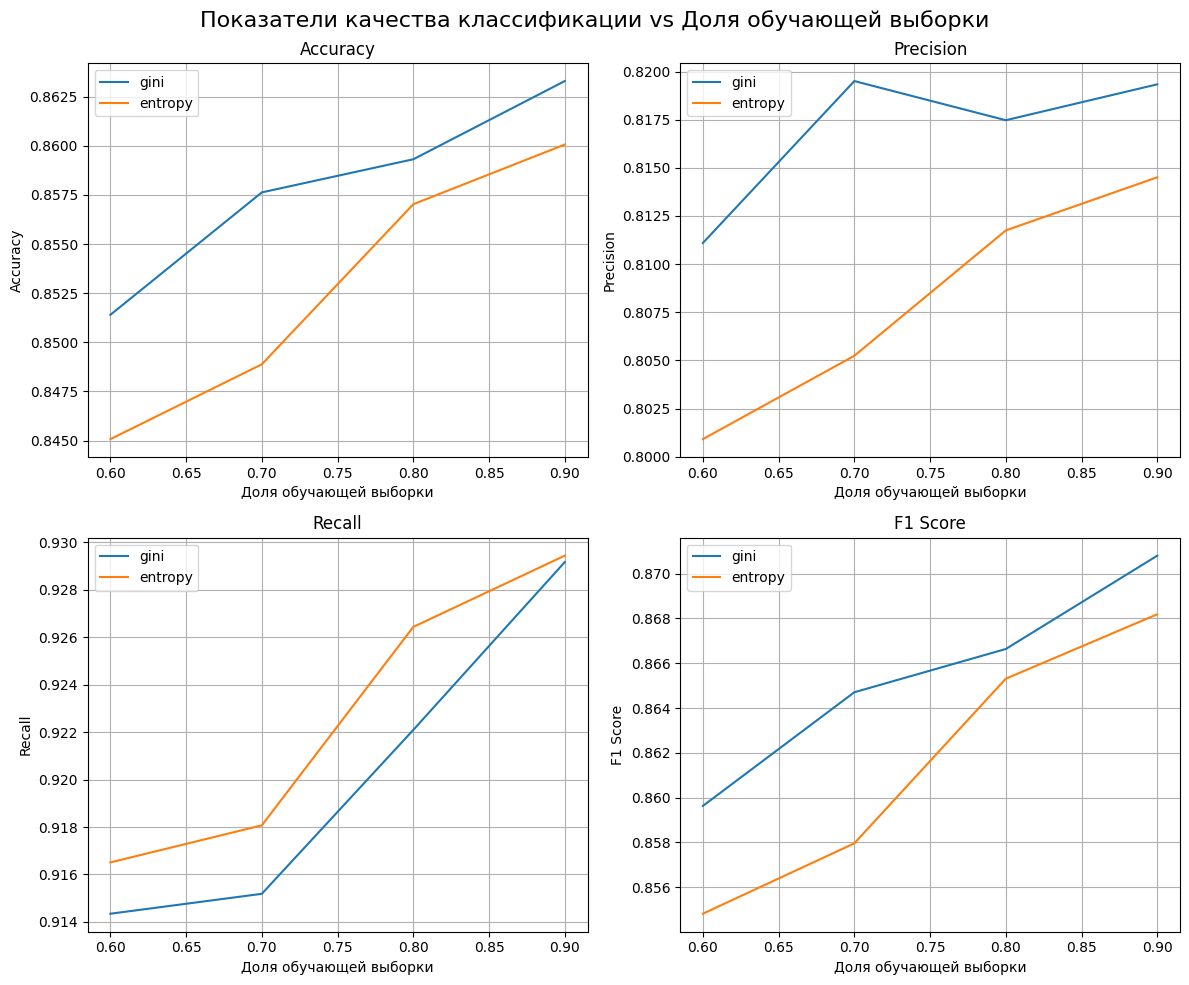

In [14]:
import matplotlib.pyplot as plt

# Создаем подграфики для каждого показателя качества
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.flatten()
metrics = ['accuracy', 'precision', 'recall', 'f1']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Проходим по каждому показателю качества
for i, metric in enumerate(metrics):
    # Проходим по каждому критерию
    for criterion in criteria:
        # Построение графика для текущего критерия
        axes[i].plot(results[criterion]['train_test_ratio'], results[criterion][metric], label=criterion)

    # Настройка внешнего вида графика
    axes[i].set_title(metric_names[i])
    axes[i].set_xlabel('Доля обучающей выборки')
    axes[i].set_ylabel(metric_names[i])
    axes[i].legend()
    axes[i].grid(True)

# Установка общего заголовка
fig.suptitle('Показатели качества классификации vs Доля обучающей выборки', fontsize=16)
plt.tight_layout()
plt.show()